In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, plot_confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


%matplotlib inline

# Установим тип графиков
sns.set(style="ticks")

# Для лучшего качество графиков
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

# Установим ширину экрана для отчета
pd.set_option("display.width", 80)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Загрузим набор данных и выведем её первые пять записей
data = pd.read_csv('/heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# Вычислим размер датасета 
data.shape

(303, 14)

In [4]:
# Увидим, из каких колонок состоит датасет
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [5]:
# Поймем какими типами данных заполнены колонки 
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [6]:
# Проверим наличие пустых значений
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [7]:
# Убедимся, что целевой признак
# для задачи бинарной классификации содержит только 0 и 1
data['exang'].unique()

array([0, 1])

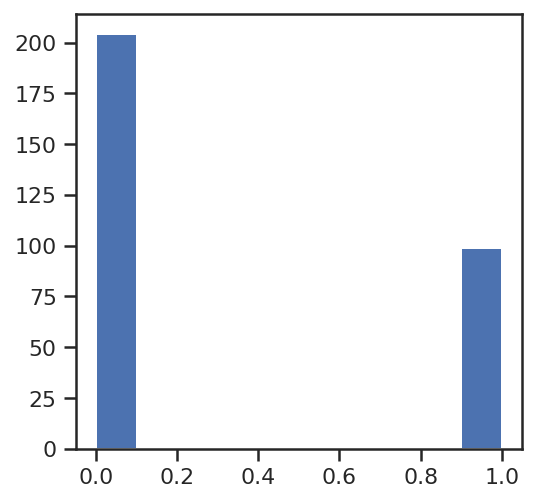

In [8]:
# Оценим дисбаланс классов для Heart
fig, ax = plt.subplots(figsize=(4,4)) 
plt.hist(data['exang'])
plt.show()

In [9]:
data['exang'].value_counts()

0    204
1     99
Name: exang, dtype: int64

In [10]:
# посчитаем дисбаланс классов
total = data.shape[0]
class_1, class_0 = data['exang'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 2)*100, round(class_1 / total, 2)*100))

Класс 0 составляет 33.0%, а класс 1 составляет 67.0%.


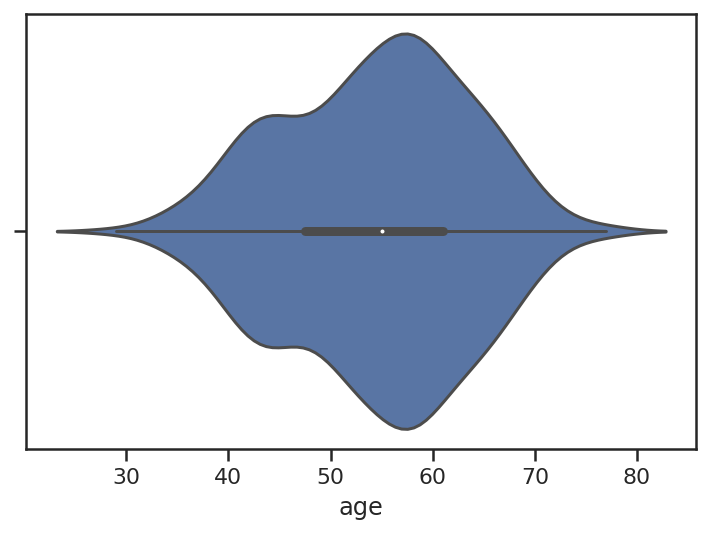

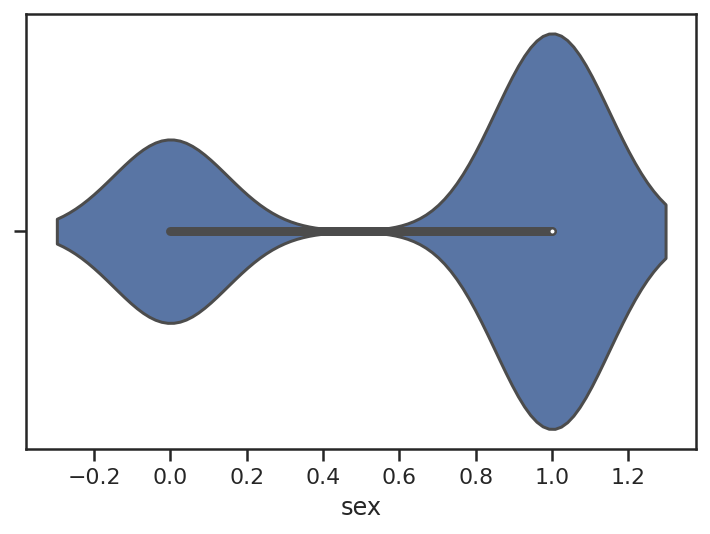

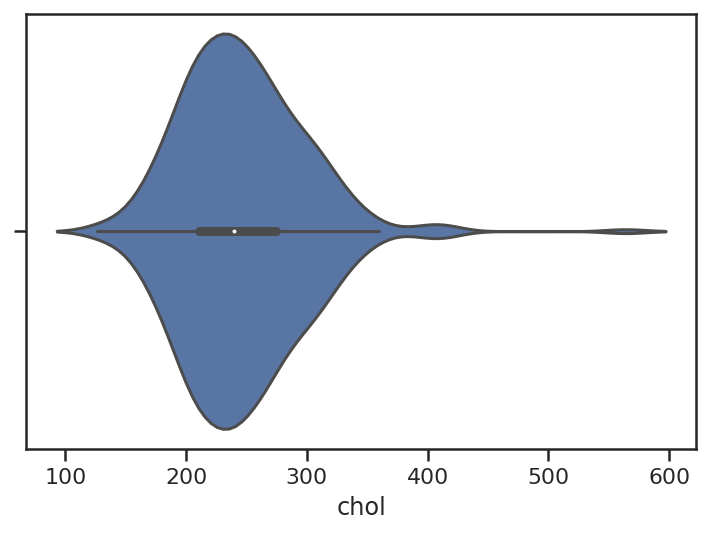

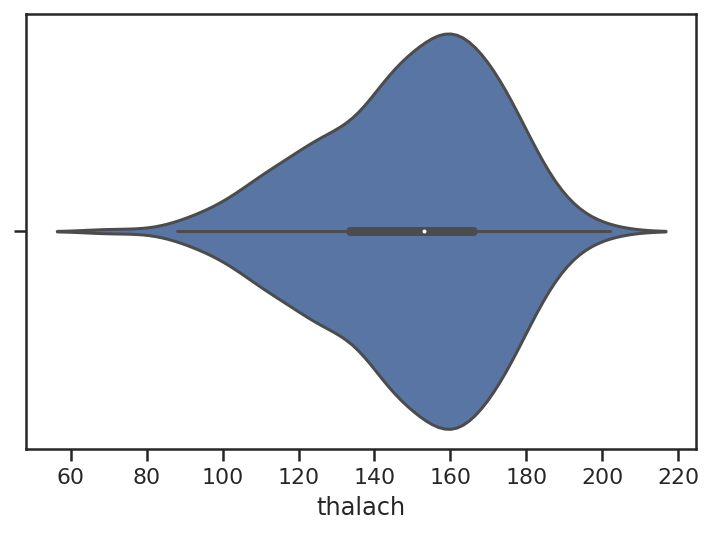

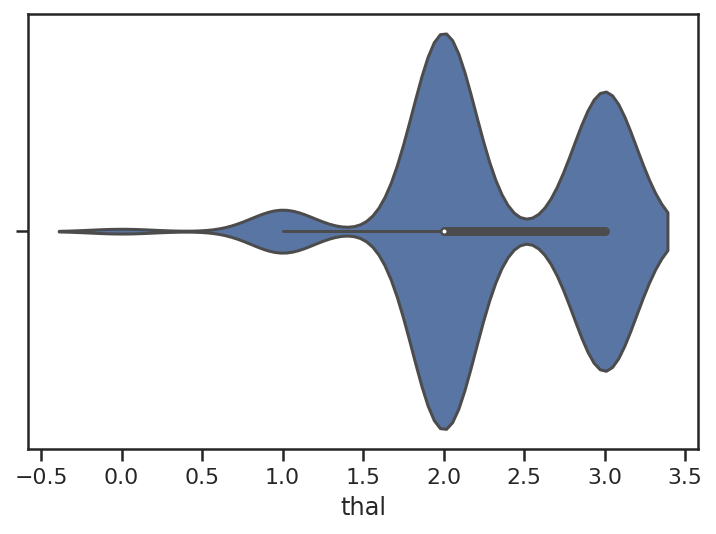

In [11]:
# Скрипичные диаграммы для некоторых колонок колонок
for col in ['age', 'sex', 'chol', 'thalach', 'thal']:
    sns.violinplot(x=data[col])
    plt.show()

In [0]:
# Числовые колонки для масштабирования
scale_cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'oldpeak', 'slope', 'ca', 'thal', 'target']

In [0]:
sc = MinMaxScaler()
sc_data = sc.fit_transform(data[scale_cols])

In [0]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data[new_col_name] = sc_data[:,i]

In [15]:
#Выведем первые 5 строк и убедимся, что масштабированные данные были успешно добавлены в набор
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_scaled,sex_scaled,cp_scaled,trestbps_scaled,chol_scaled,fbs_scaled,restecg_scaled,thalach_scaled,oldpeak_scaled,slope_scaled,ca_scaled,thal_scaled,target_scaled
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.370968,0.0,0.0,0.333333,1.0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.564516,0.0,0.0,0.666667,1.0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.225806,1.0,0.0,0.666667,1.0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.129032,1.0,0.0,0.666667,1.0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,0.096774,1.0,0.0,0.666667,1.0


In [16]:
#Выведем последние 5 строк
data.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_scaled,sex_scaled,cp_scaled,trestbps_scaled,chol_scaled,fbs_scaled,restecg_scaled,thalach_scaled,oldpeak_scaled,slope_scaled,ca_scaled,thal_scaled,target_scaled
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0,0.583333,0.0,0.000000,0.433962,0.262557,0.0,0.5,0.396947,0.032258,0.5,0.00,1.000000,0.0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0,0.333333,1.0,1.000000,0.150943,0.315068,0.0,0.5,0.465649,0.193548,0.5,0.00,1.000000,0.0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0,0.812500,1.0,0.000000,0.471698,0.152968,1.0,0.5,0.534351,0.548387,0.5,0.50,1.000000,0.0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0,0.583333,1.0,0.000000,0.339623,0.011416,0.0,0.5,0.335878,0.193548,0.5,0.25,1.000000,0.0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0,0.583333,0.0,0.333333,0.339623,0.251142,0.0,0.0,0.786260,0.000000,0.5,0.25,0.666667,0.0


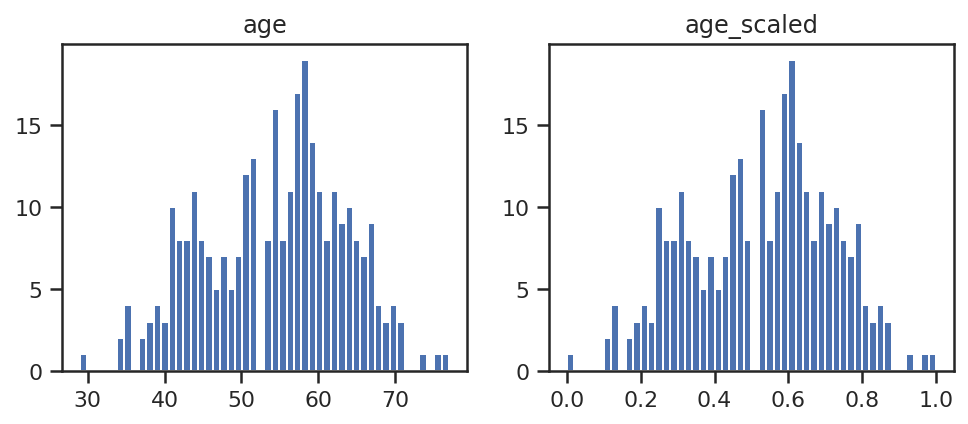

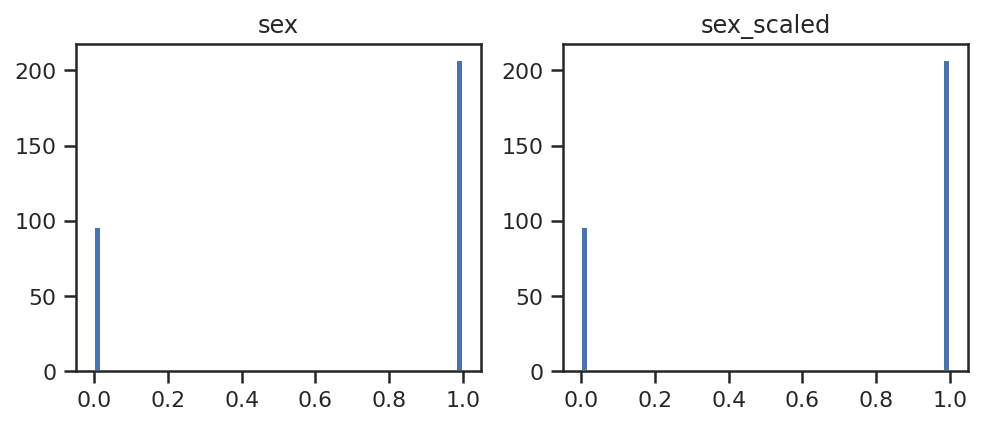

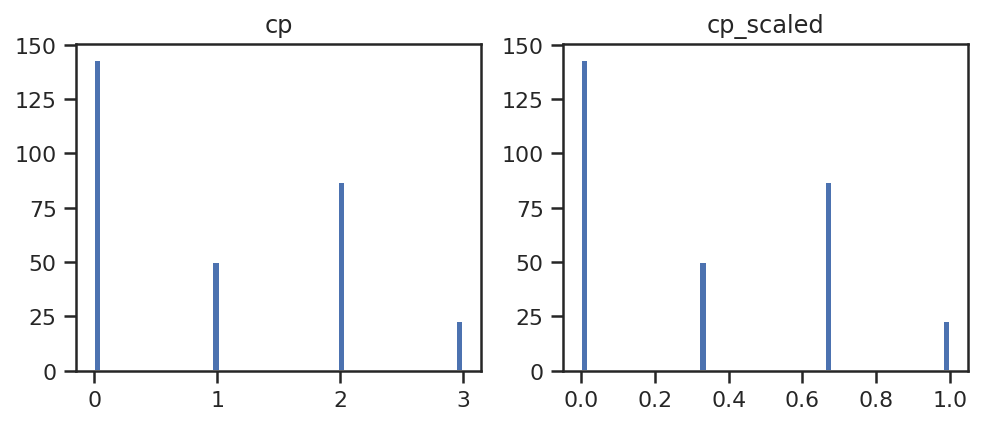

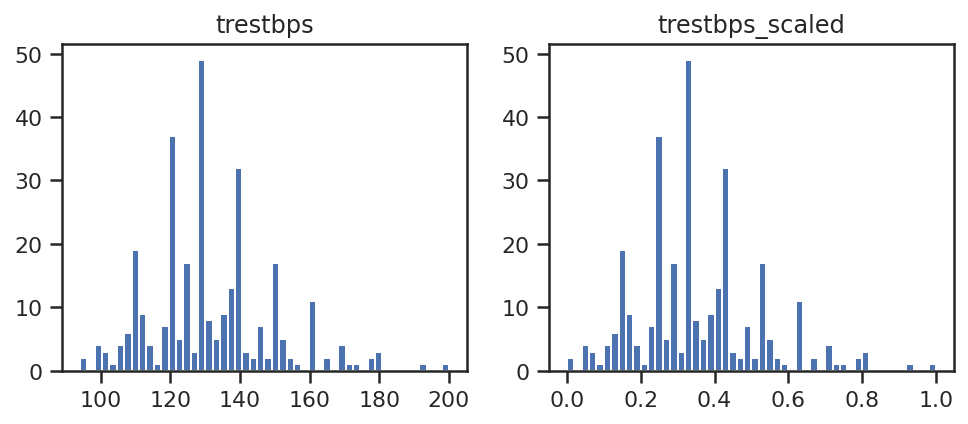

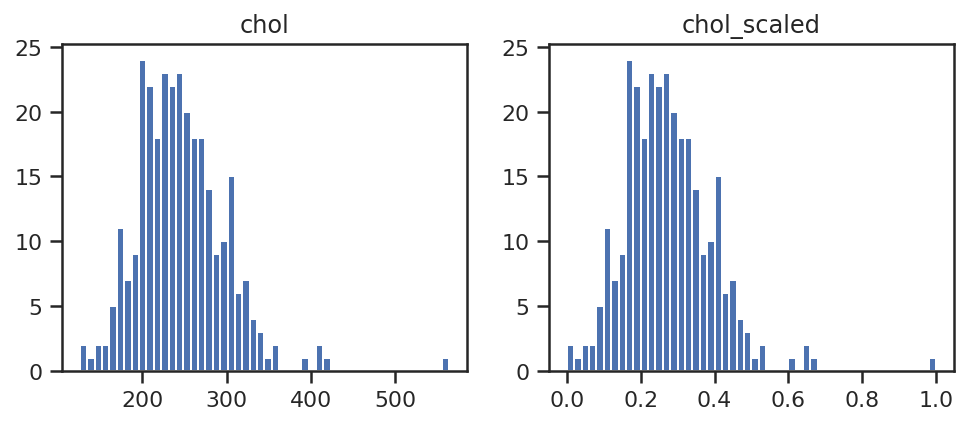

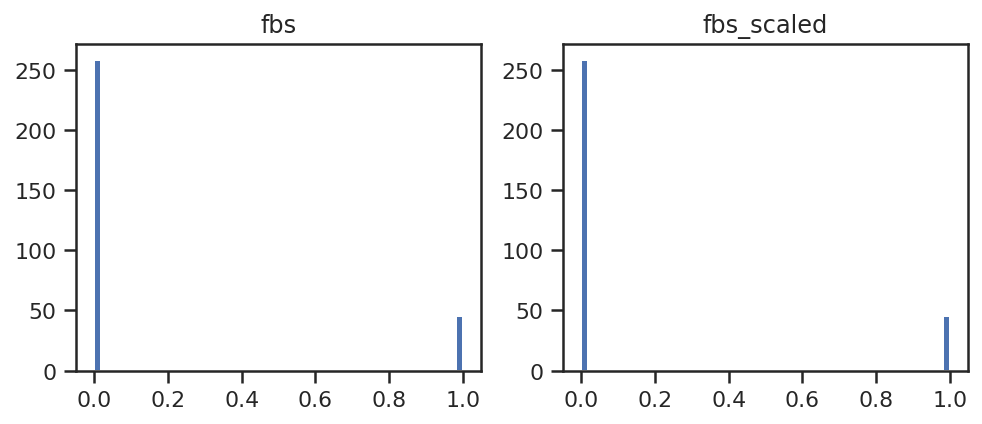

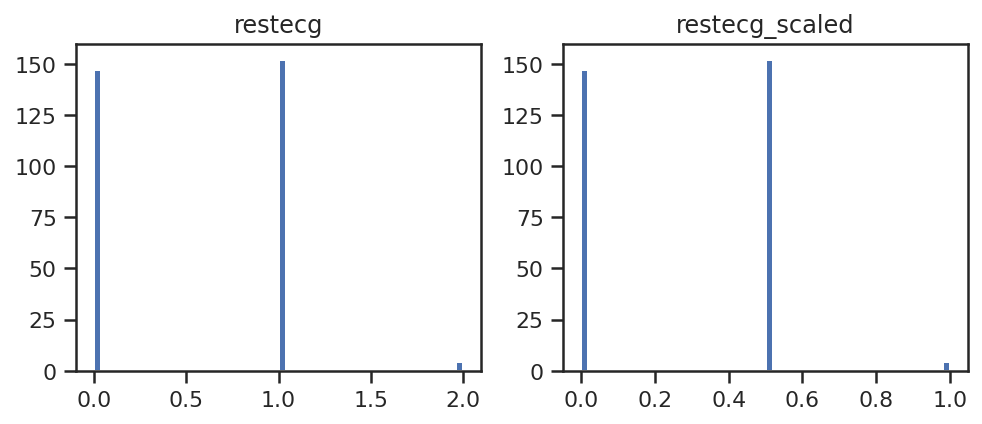

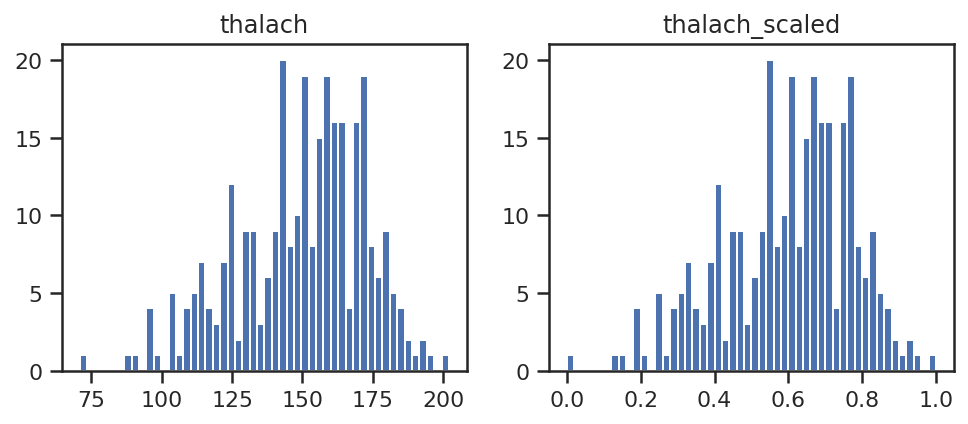

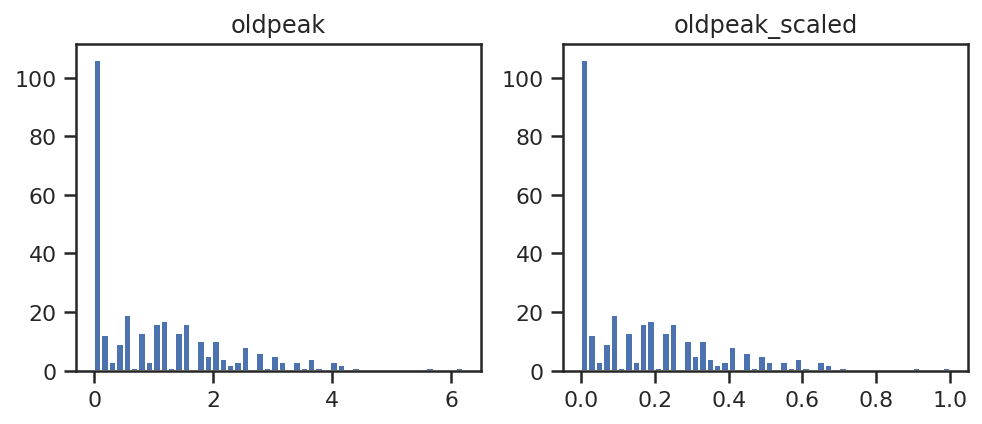

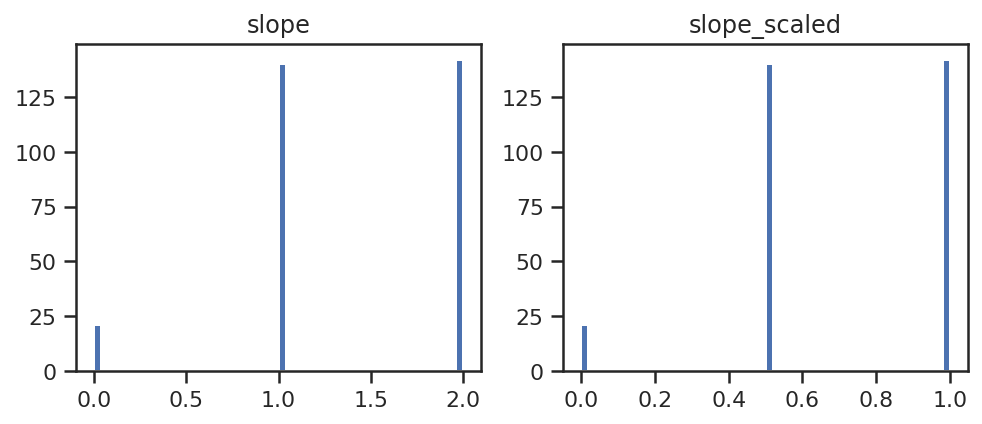

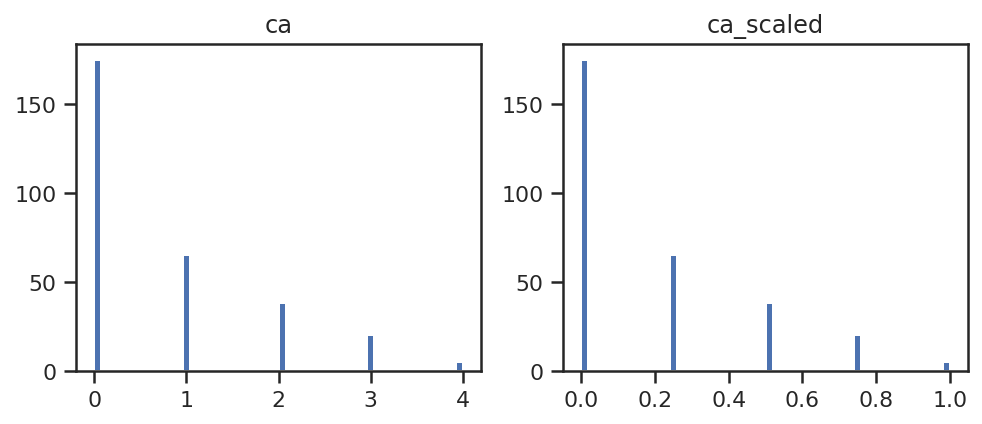

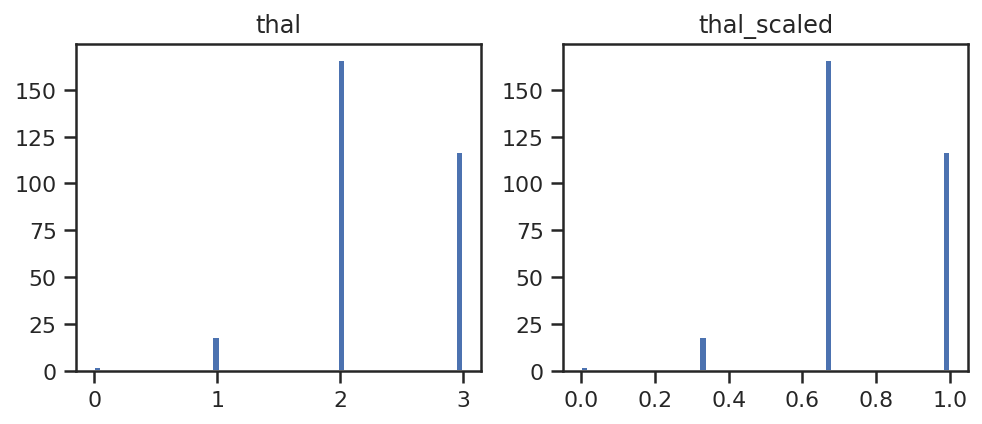

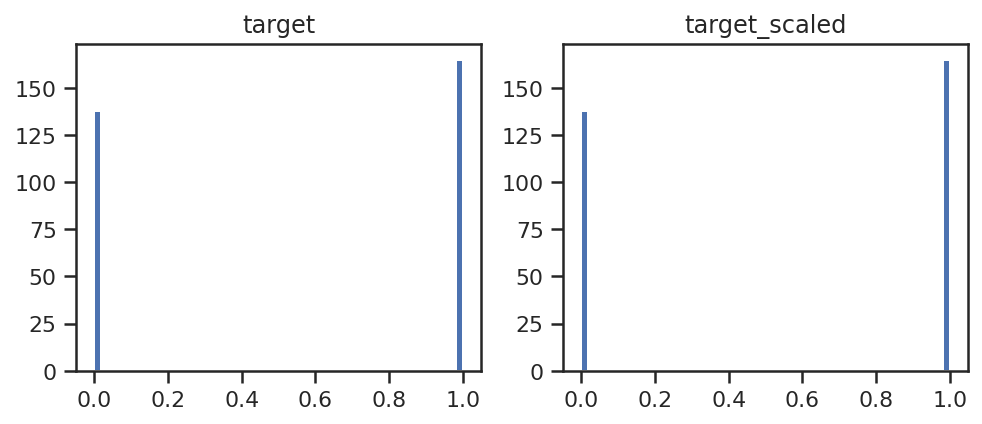

In [17]:
# Убедимся, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(data[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

In [18]:
corr_cols_1 = scale_cols + ['exang']
corr_cols_1

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'target',
 'exang']

In [19]:
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['exang']
corr_cols_2

['age_scaled',
 'sex_scaled',
 'cp_scaled',
 'trestbps_scaled',
 'chol_scaled',
 'fbs_scaled',
 'restecg_scaled',
 'thalach_scaled',
 'oldpeak_scaled',
 'slope_scaled',
 'ca_scaled',
 'thal_scaled',
 'target_scaled',
 'exang']

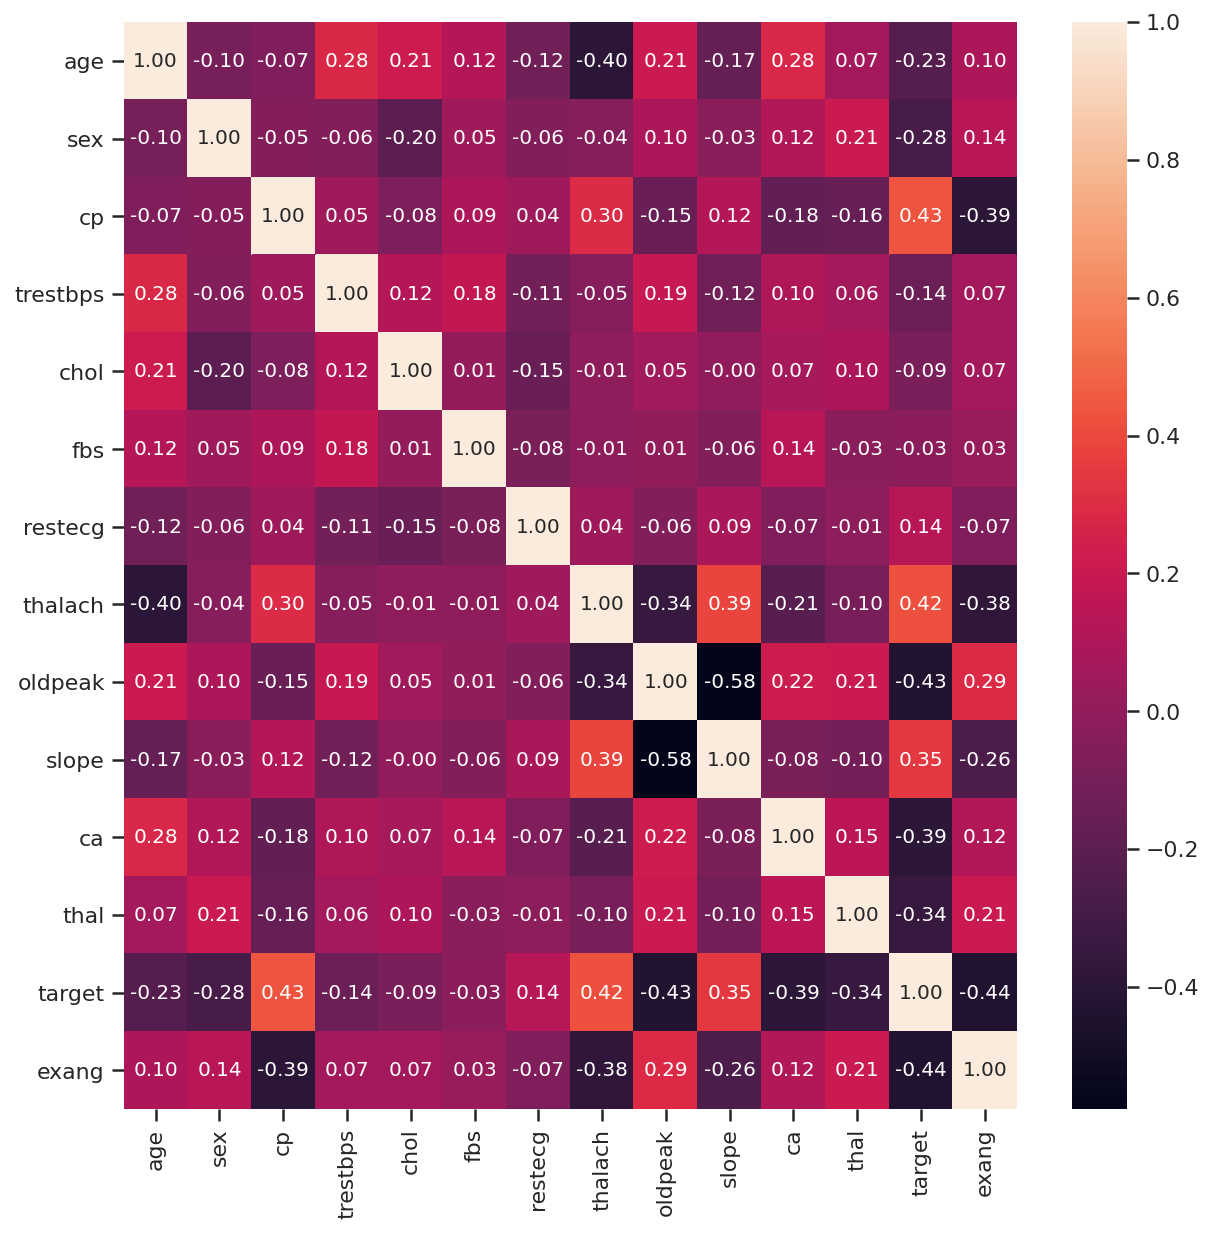

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data[corr_cols_1].corr(), annot=True, fmt='.2f')

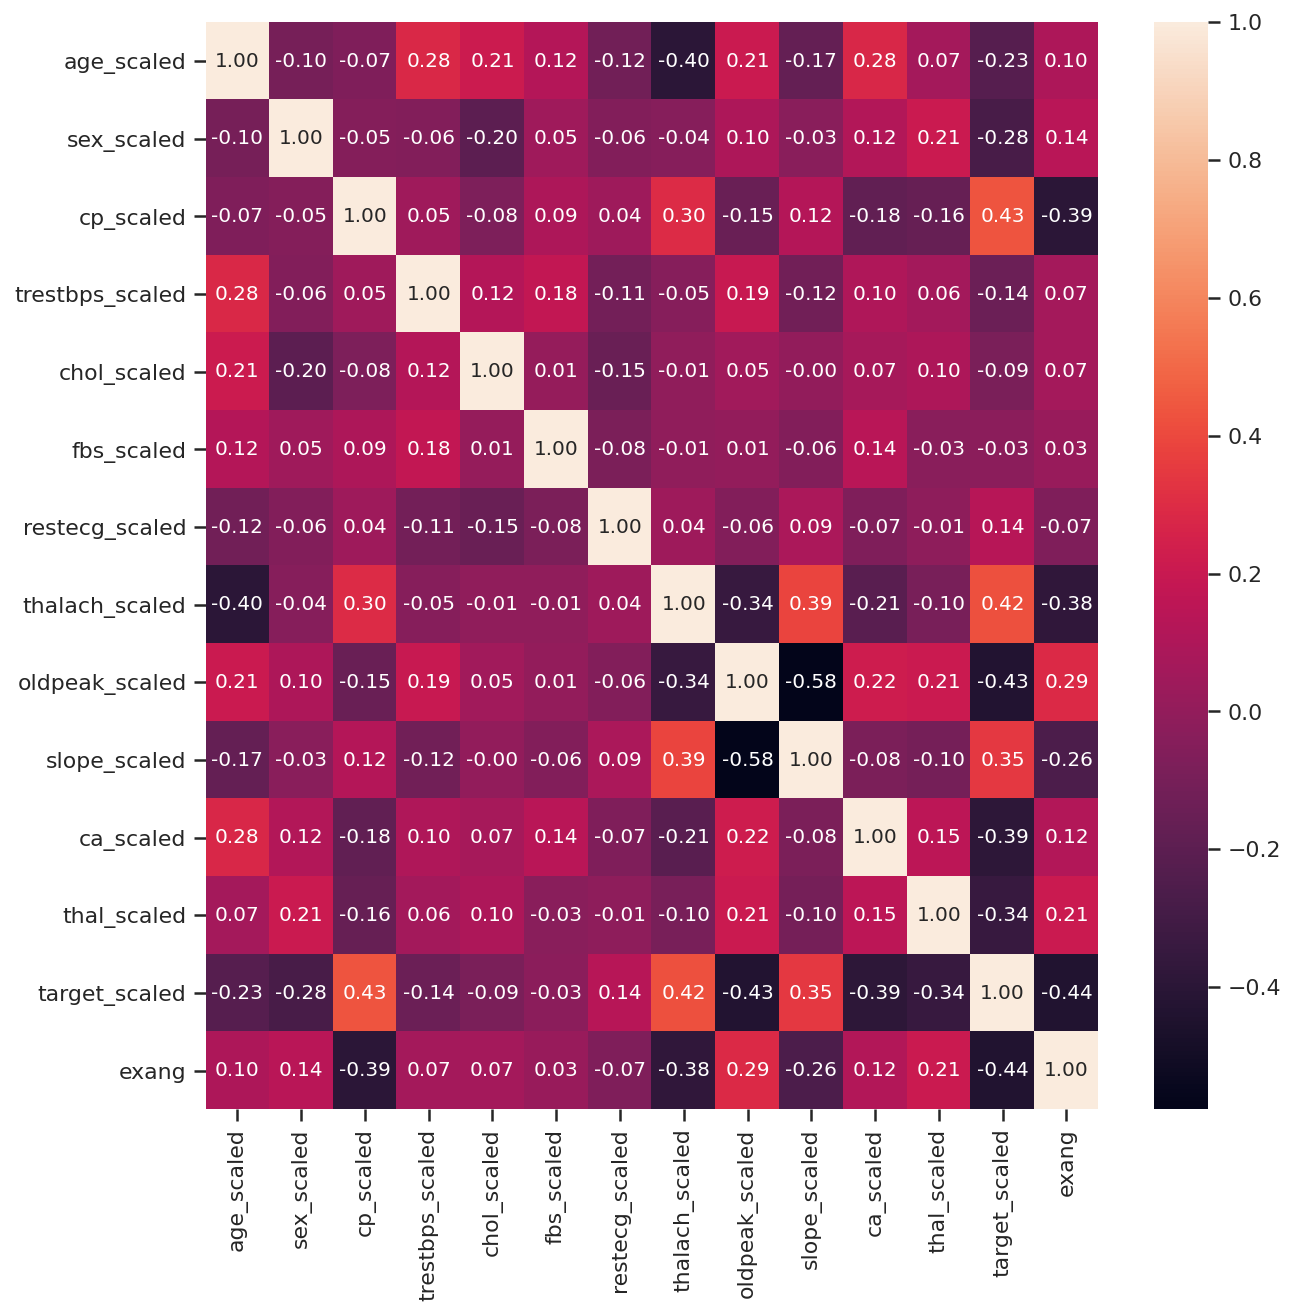

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data[corr_cols_2].corr(), annot=True, fmt='.2f')

In [0]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label=1, average='micro'):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [0]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

In [0]:
class_cols = ['age_scaled', 'sex_scaled', 'cp_scaled', 'restecg_scaled', 'thalach_scaled', 'oldpeak_scaled', 'slope_scaled', 'ca_scaled', 'thal_scaled', 'target_scaled']

In [25]:
X = data[class_cols]
y = data['exang']
X.shape

(303, 10)

In [26]:
# С использованием метода train_test_split разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (227, 10)
X_test: (76, 10)
y_train: (227,)
y_test: (76,)


In [0]:
# Модели
models = {'KNN_3':KNeighborsClassifier(n_neighbors=3),
          'SVC':SVC(),
          'Tree':DecisionTreeClassifier(),
          'RF':RandomForestClassifier(),
          'GB':GradientBoostingClassifier()}

In [0]:
# Сохранение метрик
metricLogger = MetricLogger()

In [0]:
def test_model(model_name, model, metricLogger):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    metricLogger.add('precision', model_name, precision)
    metricLogger.add('recall', model_name, recall)
    metricLogger.add('accuracy', model_name, accuracy)
    metricLogger.add('roc_auc', model_name, roc_auc)
    
    print('*****************************************************')
    print(model)
    print('*****************************************************')
    draw_roc_curve(y_test, y_pred)
    
    plot_confusion_matrix(model, X_test, y_test, 
                      display_labels=['0','1'], 
                      cmap=plt.cm.Blues, normalize='true')
    plt.show()

*****************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
*****************************************************


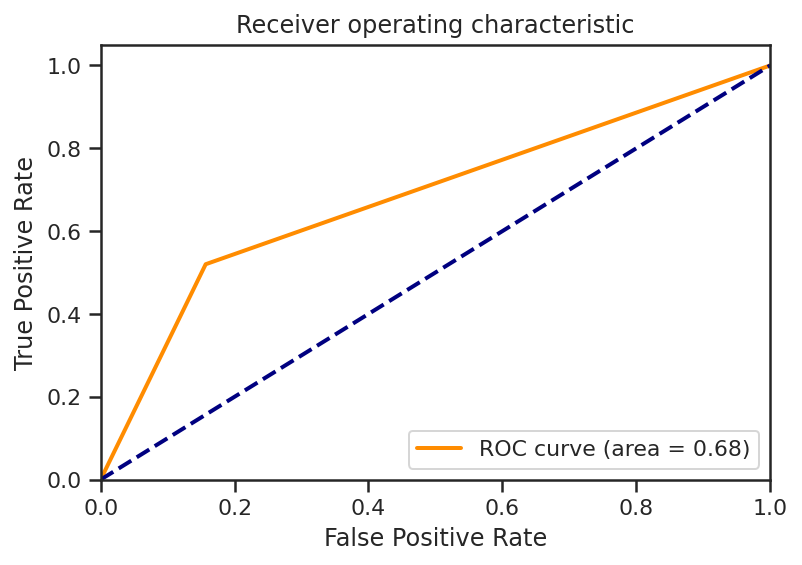

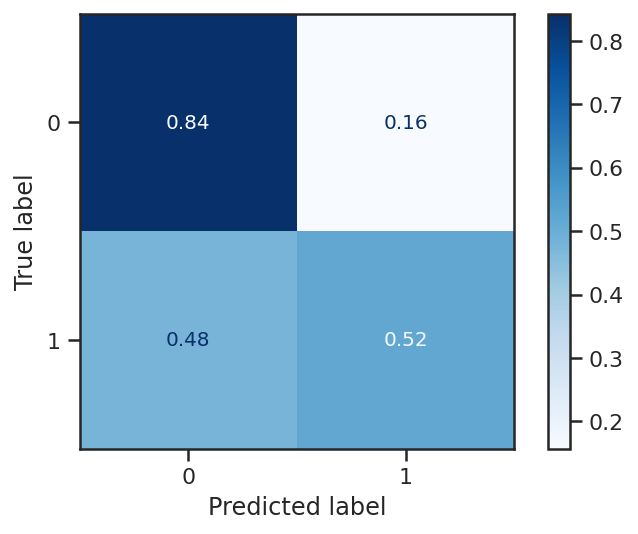

*****************************************************
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
*****************************************************


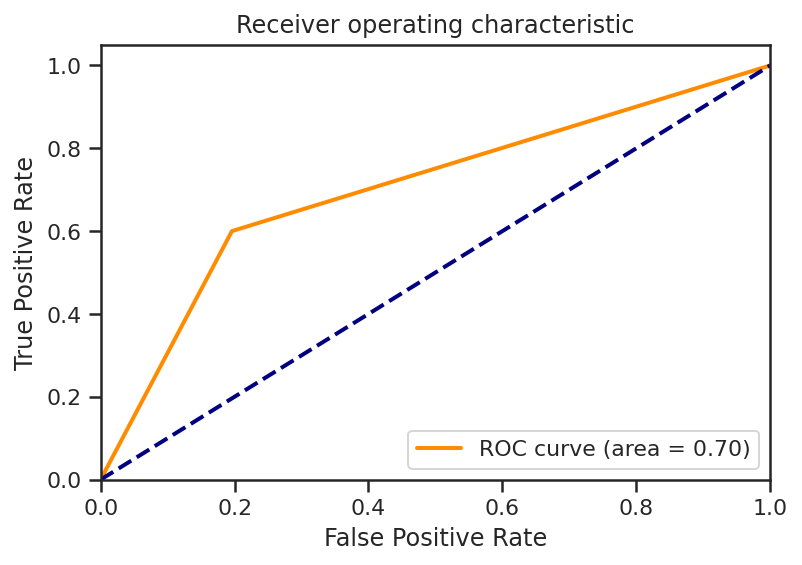

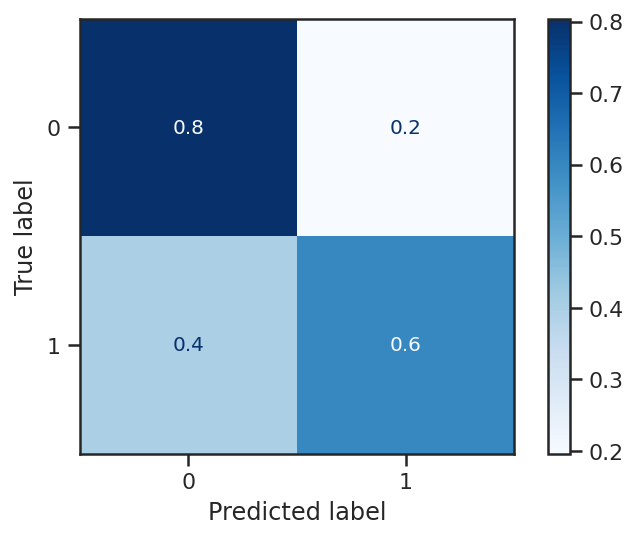

*****************************************************
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
*****************************************************


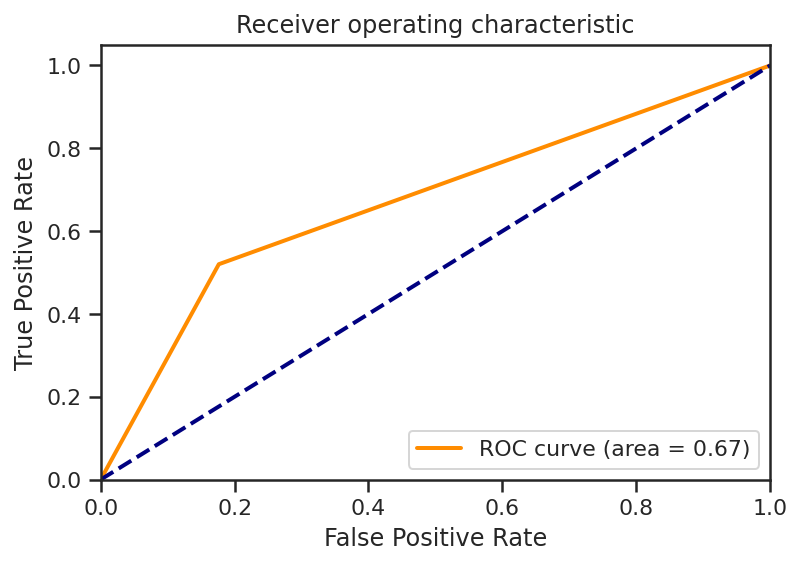

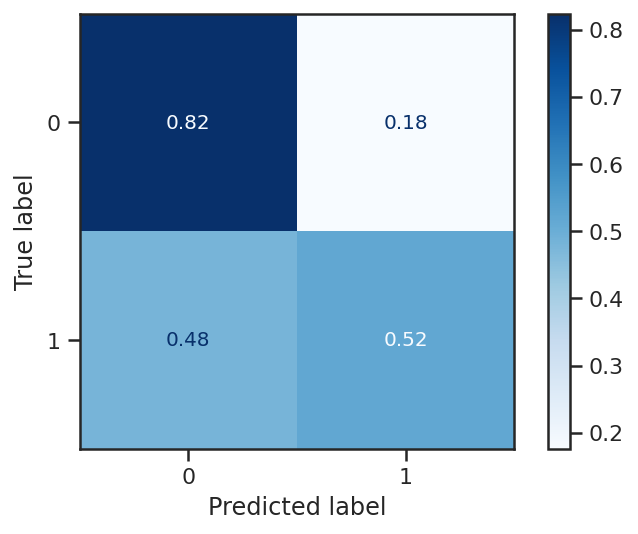

*****************************************************
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
*****************************************************


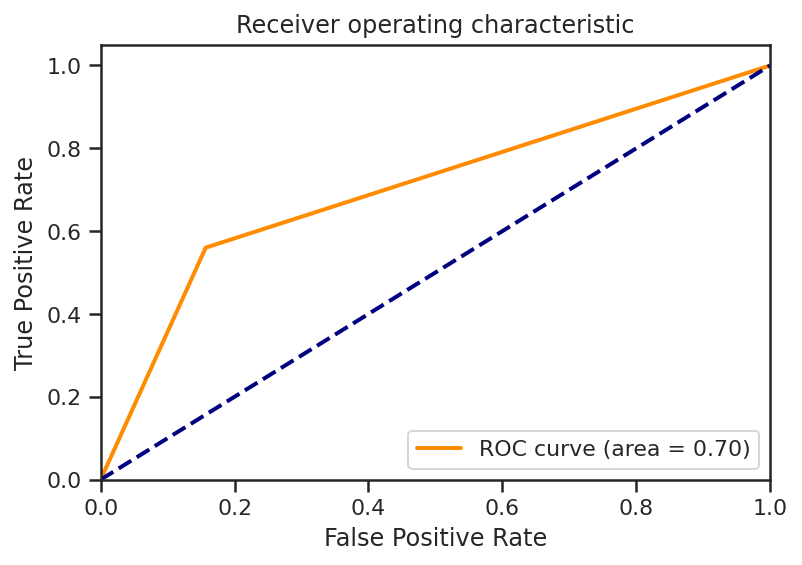

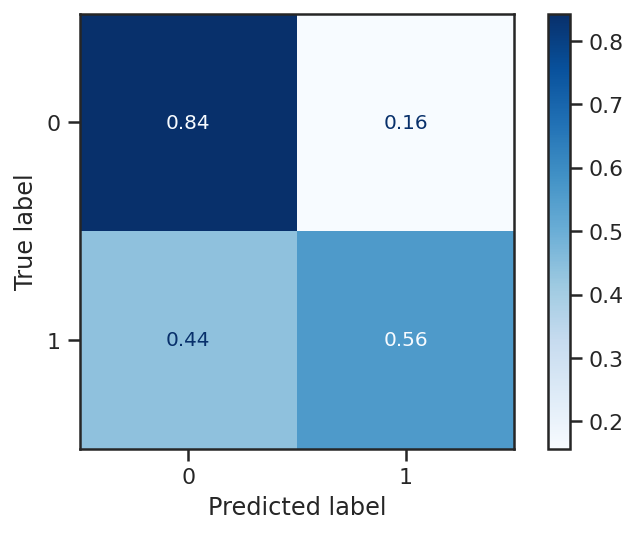

*****************************************************
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
*****************************************************


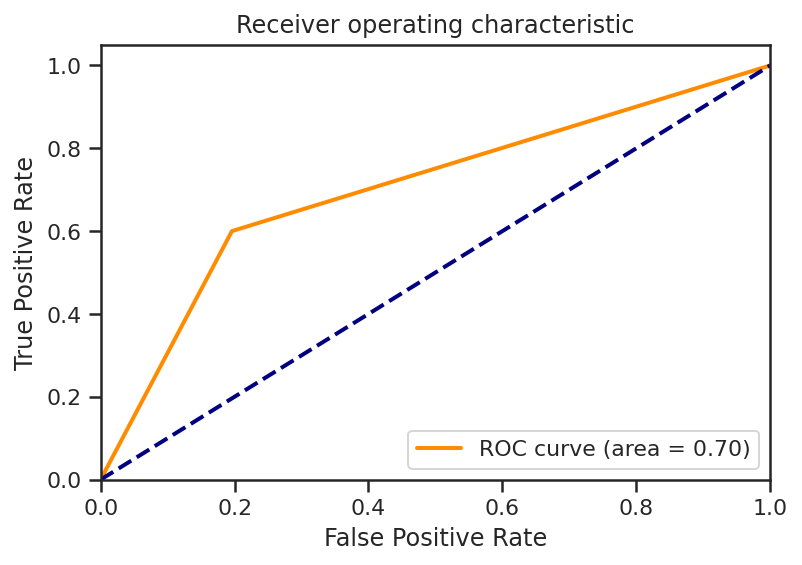

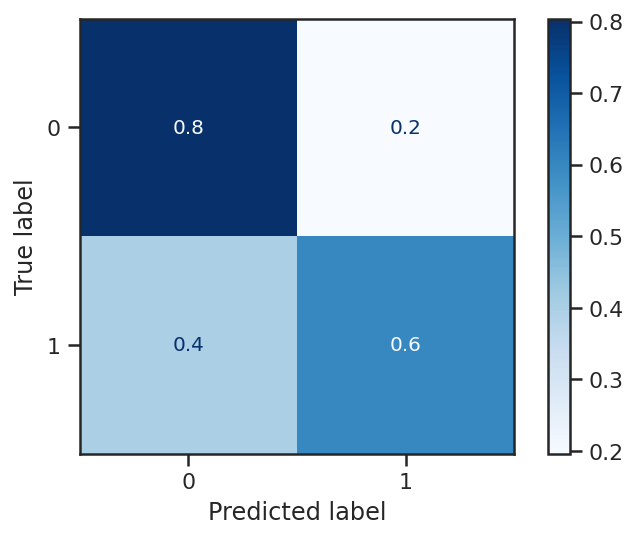

In [30]:
for model_name, model in models.items():
    test_model(model_name, model, metricLogger)

In [31]:
n_range = np.array(range(0,30,1))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])}]

In [32]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy', n_jobs = -1)
clf_gs.fit(X, y)

CPU times: user 227 ms, sys: 35.4 ms, total: 263 ms
Wall time: 2.13 s


In [33]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [34]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 20}

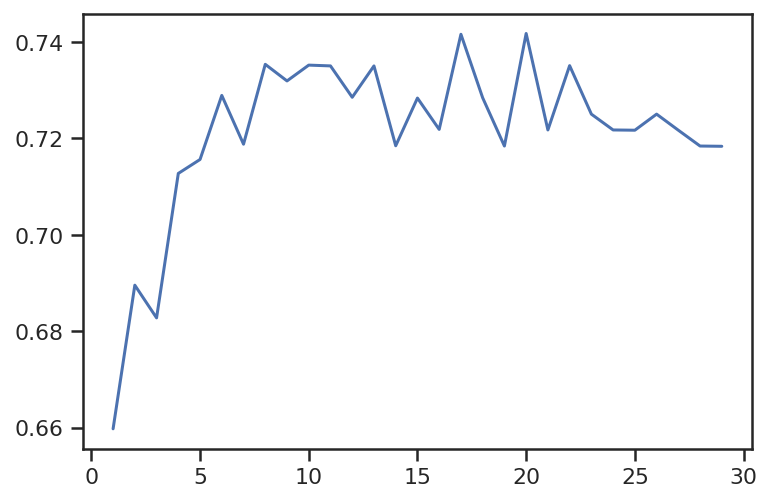

In [35]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

*****************************************************
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
*****************************************************


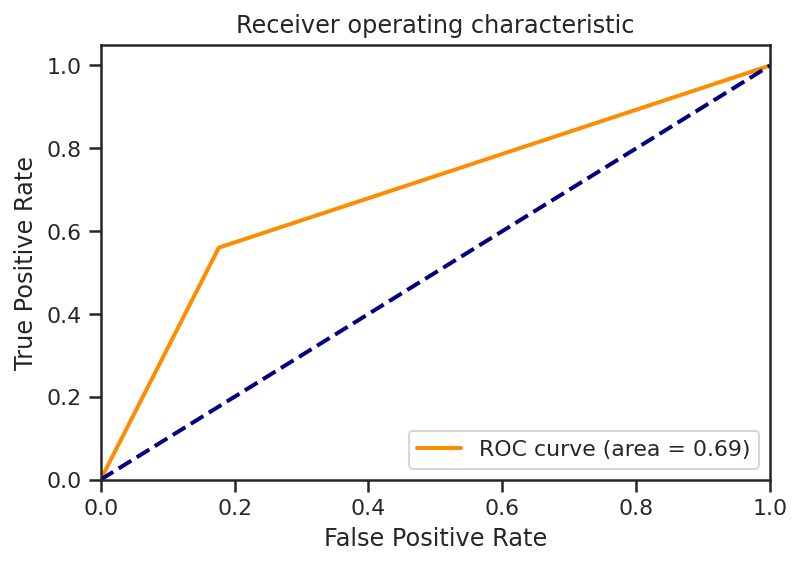

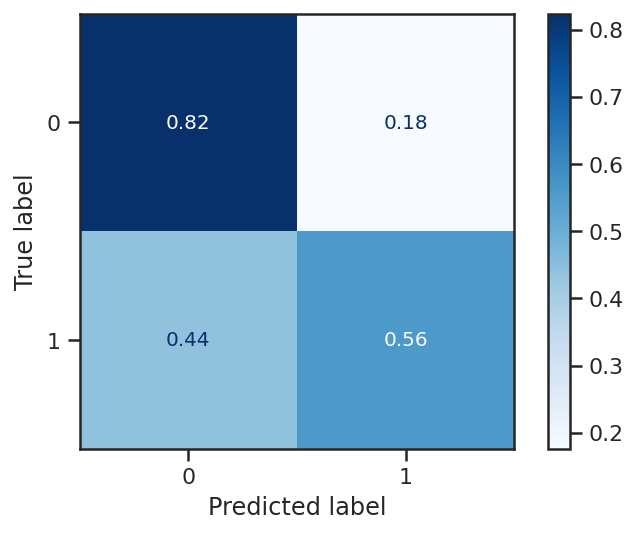

In [36]:
test_model('KNN_5', KNeighborsClassifier(n_neighbors=5), metricLogger)

In [37]:
# Метрики качества модели
metrics = metricLogger.df['metric'].unique()
metrics

array(['precision', 'recall', 'accuracy', 'roc_auc'], dtype=object)

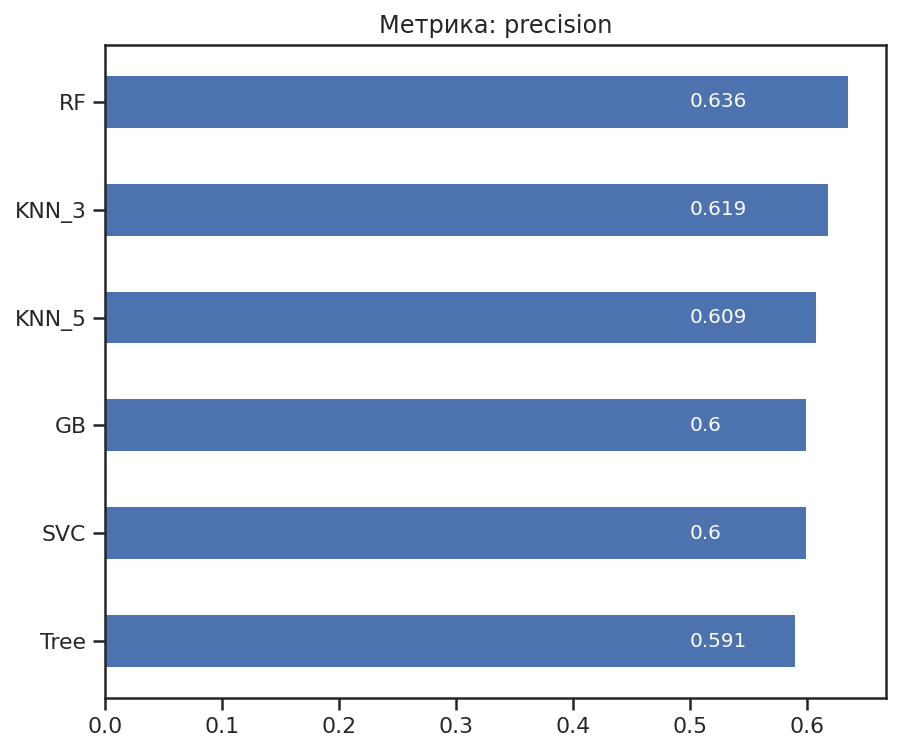

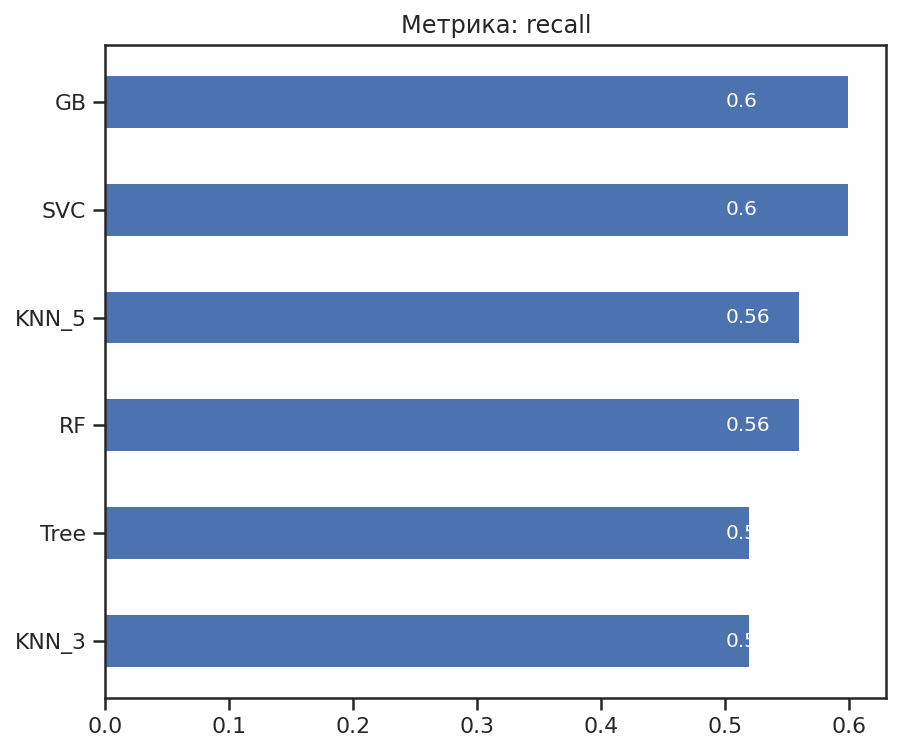

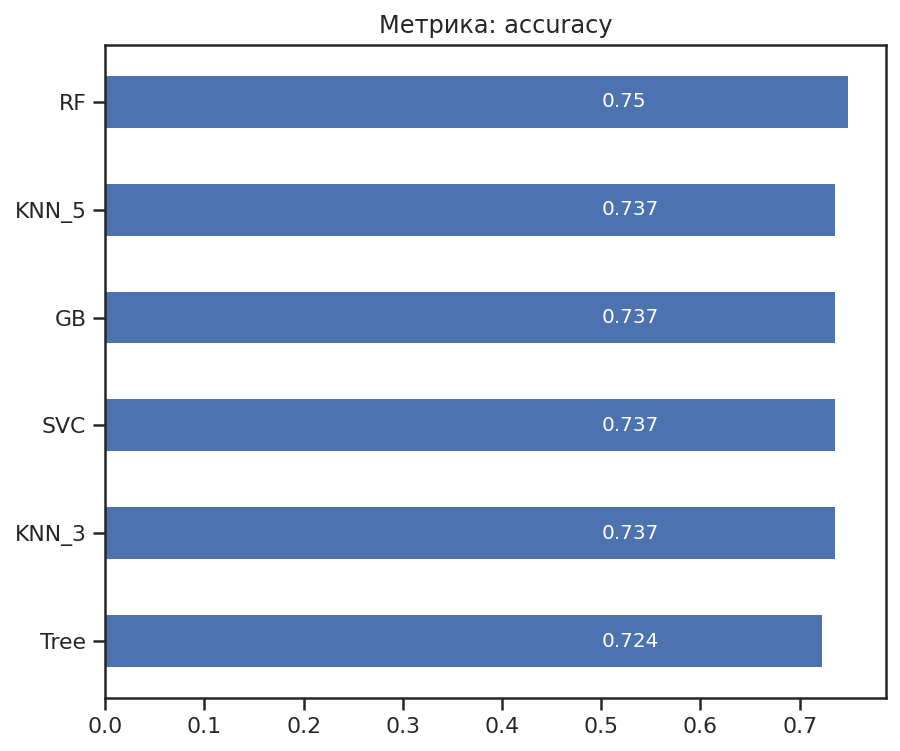

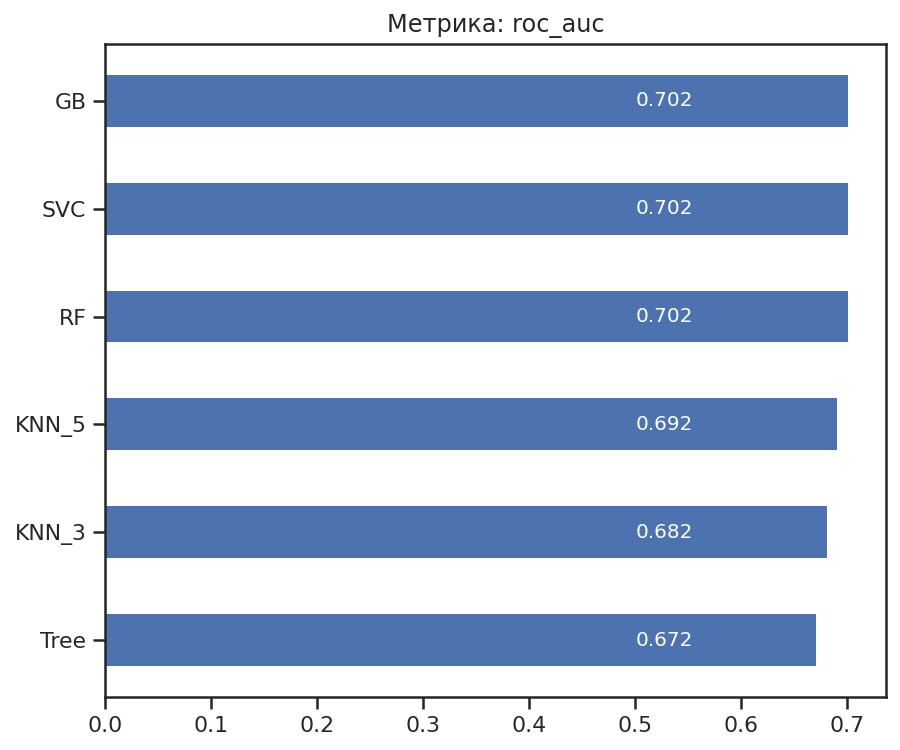

In [38]:
# Построим графики метрик качества модели
for metric in metrics:
    metricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))